In [76]:
import numpy as np
import pandas as pd
import os
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sbn

In [77]:
#read train and test dataset 
TRAIN_PATH = "~/developement/cmpe257/new-york-city-taxi-fare-prediction/train.csv"
TEST_PATH = "~/developement/cmpe257/new-york-city-taxi-fare-prediction/test.csv"

In [78]:
train_temp = pd.read_csv(TRAIN_PATH, nrows = 5)
print("training dataset head:")
print(train_temp)


training dataset head:
                             key  fare_amount          pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5  2009-06-15 17:26:21 UTC   
1    2010-01-05 16:52:16.0000002         16.9  2010-01-05 16:52:16 UTC   
2   2011-08-18 00:35:00.00000049          5.7  2011-08-18 00:35:00 UTC   
3    2012-04-21 04:30:42.0000001          7.7  2012-04-21 04:30:42 UTC   
4  2010-03-09 07:51:00.000000135          5.3  2010-03-09 07:51:00 UTC   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  
0                1  
1                1  
2     

In [79]:
test_temp = pd.read_csv(TEST_PATH, nrows=5)
print("test dataset head:")
test_temp.head

test dataset head:


<bound method NDFrame.head of                            key          pickup_datetime  pickup_longitude  \
0  2015-01-27 13:08:24.0000002  2015-01-27 13:08:24 UTC        -73.973320   
1  2015-01-27 13:08:24.0000003  2015-01-27 13:08:24 UTC        -73.986862   
2  2011-10-08 11:53:44.0000002  2011-10-08 11:53:44 UTC        -73.982524   
3  2012-12-01 21:12:12.0000002  2012-12-01 21:12:12 UTC        -73.981160   
4  2012-12-01 21:12:12.0000003  2012-12-01 21:12:12 UTC        -73.966046   

   pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  
0        40.763805         -73.981430         40.743835                1  
1        40.719383         -73.998886         40.739201                1  
2        40.751260         -73.979654         40.746139                1  
3        40.767807         -73.990448         40.751635                1  
4        40.789775         -73.988565         40.744427                1  >

In [80]:
#chunksize = 1000

train_types = {'fare_amount': 'float32',
              'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

test_types =  {'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

train_cols = list(train_types.keys())
test_cols = list(test_types.keys())

def clean_df(PATH, cols, datatypes, chunksize):
    if PATH == TEST_PATH:
        df_list = []
        for chunk in pd.read_csv(PATH, usecols = cols, dtype=datatypes, chunksize=chunksize):
            chunk['pickup_datetime'] = chunk['pickup_datetime'].str.slice(0, 16)
            chunk['pickup_datetime'] = pd.to_datetime(chunk['pickup_datetime'], utc=True, 
                                                      format='%Y-%m-%d %H:%M')
            
            #add datetime features to the data 
            #pickup_datetime -> hour, month, year, isWeekday, day
            add_datetime_features(chunk)
            
            #removing data with missing points -> (does not affect the number of sample points)
            #chunk = chunk.dropna(how = 'any', axis = 'rows')
            
            #add distance travelled by the cab to dataframe
            chunk['haversine_distnace'] = add_distance(chunk.pickup_latitude, chunk.pickup_longitude,
                        chunk.dropoff_latitude, chunk.dropoff_longitude)

            #add direction of the distance
            chunk['direction'] = calculate_direction(chunk.pickup_latitude, chunk.pickup_longitude,
                        chunk.dropoff_latitude, chunk.dropoff_longitude)
            
            #add a distance_from_JFK_airport to the features as the fare would be more for places closer to airport
            pickup_JFK, dropoff_JFK = add_dist_from_jfk(chunk)
            chunk['JFK_distance'] = pd.concat([pickup_JFK, dropoff_JFK], axis=1).min(axis=1)

            df_list.append(chunk)
            #print(len(df_list))
        return pd.concat(df_list)
    
    elif(PATH == TRAIN_PATH):
        #X_df_list = []
        #y_df_list = []
        df_list = []
        for chunk in pd.read_csv(PATH, usecols = cols, dtype=datatypes, chunksize=chunksize):  
            #converting pickup datetime to proper format
            chunk['pickup_datetime'] = chunk['pickup_datetime'].str.slice(0, 16)
            chunk['pickup_datetime'] = pd.to_datetime(chunk['pickup_datetime'], utc=True, 
                                                      format='%Y-%m-%d %H:%M')
            #outlier removal
            #remove rows with passenger count 0 and more than 6
            chunk = chunk[(chunk['passenger_count'] > 0) & (chunk['passenger_count'] < 7) ]
            
            #remove rows with fare amount less than $2 and greater than $400 
            chunk = chunk[(chunk['fare_amount'] > 2.0) & (chunk['fare_amount'] < 400.0)]     

            # Remove data with invalid coordinates
            # NY Coordinates are around 40 N and 74 W
            # 1 degree is equal to around 69 miles
            # So this range should be fine for our purpose
            chunk = chunk[(chunk['pickup_latitude'] < 42.0) & (chunk['pickup_latitude'] > 39.0)]
            chunk = chunk[(chunk['dropoff_latitude'] < 42.0) & (chunk['dropoff_latitude'] > 39.0)]
            chunk = chunk[(chunk['pickup_longitude'] < -70.0) & (chunk['pickup_longitude'] > -75.0)]
            chunk = chunk[(chunk['dropoff_longitude'] < -70.0) & (chunk['dropoff_longitude'] > -75.0)]       
            
            #add datetime features to the data 
            #pickup_datetime -> hour, month, year, isWeekday, day
            add_datetime_features(chunk)
            
            #removing data with missing points -> (does not affect the number of sample points)
            #chunk = chunk.dropna(how = 'any', axis = 'rows')
            
            #add distance travelled by the cab to dataframe
            chunk['haversine_distnace'] = add_distance(chunk.pickup_latitude, chunk.pickup_longitude,
                        chunk.dropoff_latitude, chunk.dropoff_longitude)

            #add direction of the distance
            chunk['direction'] = calculate_direction(chunk.pickup_latitude, chunk.pickup_longitude,
                        chunk.dropoff_latitude, chunk.dropoff_longitude)            
            
            chunk = chunk[(chunk['haversine_distnace'] > 0.1) & (chunk['haversine_distnace'] < 100)] 
            
            #add a distance_from_JFK_airport to the features as the fare would be more for places closer to airport
            pickup_JFK, dropoff_JFK = add_dist_from_jfk(chunk)
            chunk['JFK_distance'] = pd.concat([pickup_JFK, dropoff_JFK], axis=1).min(axis=1)

            #appending chunks to the dataframe list
            df_list.append(chunk)
            #y_df_list.append(chunk['fare_amount'])
            #chunk.drop(labels = 'fare_amount', axis=1, inplace=True)
            #X_df_list.append(chunk)
            
        df = pd.concat(df_list)
        #X_df = pd.concat(X_df_list)
        #y_df = pd.concat(y_df_list)
        return  df

def add_datetime_features(data_chunk):
    data_chunk['hour'] = data_chunk.pickup_datetime.dt.hour
    data_chunk['day'] = data_chunk.pickup_datetime.dt.day
    data_chunk['month'] = data_chunk.pickup_datetime.dt.month
    data_chunk['weekday'] = data_chunk.pickup_datetime.dt.weekday
    data_chunk['year'] = data_chunk.pickup_datetime.dt.year
    
    return data_chunk
    
def add_distance(lat1, lon1, lat2, lon2):
    p = np.pi/180.0
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) # 2*R*asin...    

def calculate_direction(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    """
    Return distance along great radius between pickup and dropoff coordinates.
    """
    #Define earth radius (km)
    R_earth = 6371
    #Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon, 
                                                              dropoff_lat, dropoff_lon])
    #Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = pickup_lon - dropoff_lon
    
    #Compute bearing distance
    a = np.arctan2(np.sin(dlon * np.cos(dropoff_lat)),np.cos(pickup_lat) * np.sin(dropoff_lat) - np.sin(pickup_lat) * np.cos(dropoff_lat) * np.cos(dlon))
    return a

def add_dist_from_jfk(data_chunk):
    JFK_coord = (40.6413, -73.7781)
    pickup_JFK = add_distance(data_chunk['pickup_latitude'], data_chunk['pickup_longitude'], JFK_coord[0], JFK_coord[1]) 
    dropoff_JFK = add_distance(JFK_coord[0], JFK_coord[1], data_chunk['dropoff_latitude'], data_chunk['dropoff_longitude'])
    #data_chunk['JFK_distance'] = pd.concat([pickup_JFK, dropoff_JFK], axis=1).min(axis=1)

    return pickup_JFK, dropoff_JFK


train_target = clean_df(TRAIN_PATH, train_cols, train_types, chunksize = 500000)
#n_train = len(train_label)
print(train_target.shape)


#insample dataset
#train_target, train_label = clean_df(TRAIN_PATH, train_cols, train_types, chunksize = 50000)
#n_train = len(train_label)
#print(train_target.shape)

#out of samples dataset
test_dataset = clean_df(TEST_PATH, test_cols, test_types, chunksize = 2000)
print(test_dataset.shape)

(4788773, 15)
(9914, 14)


In [81]:
train_target.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,haversine_distnace,direction,JFK_distance
count,4.788773e+06,4.788773e+06,4.788773e+06,4.788773e+06,4.788773e+06,4.788773e+06,4.788773e+06,4.788773e+06,4.788773e+06,4.788773e+06,4.788773e+06,4.788773e+06,4.788773e+06,4.788773e+06
mean,1.128879e+01,-7.293399e+01,4.248479e+01,-7.293353e+01,4.248486e+01,1.691329e+00,1.351826e+01,1.571640e+01,6.269410e+00,3.041647e+00,2.011745e+03,2.116610e+00,3.073311e-01,1.247622e+01
std,9.412902e+00,1.026276e+00,1.733685e+00,1.026603e+00,1.733687e+00,1.306407e+00,6.514513e+00,8.684918e+00,3.436759e+00,1.949370e+00,1.866399e+00,2.499208e+00,1.830830e+00,2.170920e+00
min,2.200000e+00,-7.499062e+01,3.916259e+01,-7.499828e+01,3.910474e+01,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,2.009000e+03,1.000006e-01,-3.141527e+00,4.543131e-02
25%,6.000000e+00,-7.399229e+01,4.073660e+01,-7.399158e+01,4.073565e+01,1.000000e+00,9.000000e+00,8.000000e+00,3.000000e+00,1.000000e+00,2.010000e+03,8.051403e-01,-8.944210e-01,1.255035e+01
50%,8.500000e+00,-7.398214e+01,4.075338e+01,-7.398065e+01,4.075389e+01,1.000000e+00,1.400000e+01,1.600000e+01,6.000000e+00,3.000000e+00,2.012000e+03,1.363088e+00,-1.269335e-01,1.290004e+01
75%,1.250000e+01,-7.396854e+01,4.076755e+01,-7.396561e+01,4.076842e+01,2.000000e+00,1.900000e+01,2.300000e+01,9.000000e+00,5.000000e+00,2.013000e+03,2.464050e+00,2.261086e+00,1.325387e+01
max,3.860800e+02,-7.000039e+01,4.192279e+01,-7.000227e+01,4.199811e+01,6.000000e+00,2.300000e+01,3.100000e+01,1.200000e+01,6.000000e+00,2.015000e+03,9.696112e+01,3.141593e+00,2.042257e+02


In [82]:
test_dataset.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,haversine_distnace,direction,JFK_distance
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.976181,40.750954,-73.974945,40.751553,1.671273,13.467420,16.194170,6.857979,2.852834,2011.815816,1.931898,0.262677,12.456604
std,0.042799,0.033542,0.039093,0.035436,1.278747,6.868584,8.838482,3.353272,1.994451,1.803347,2.603003,1.825305,2.506147
min,-74.252190,40.573143,-74.263245,40.568974,1.000000,0.000000,1.000000,1.000000,0.000000,2009.000000,0.000000,-3.140778,0.000000
25%,-73.992500,40.736125,-73.991249,40.735253,1.000000,8.000000,9.000000,4.000000,1.000000,2010.000000,0.000000,-0.919139,12.529862
50%,-73.982327,40.753052,-73.980015,40.754065,1.000000,15.000000,16.000000,7.000000,3.000000,2012.000000,1.366828,-0.156816,12.903472
75%,-73.968012,40.767113,-73.964062,40.768757,2.000000,19.000000,25.000000,10.000000,5.000000,2014.000000,2.536426,2.202680,13.262040
max,-72.986534,41.709557,-72.990967,41.696682,6.000000,23.000000,31.000000,12.000000,6.000000,2015.000000,62.140335,3.140382,83.622993


Text(0.5, 1.0, 'Histogram ride distances in miles')

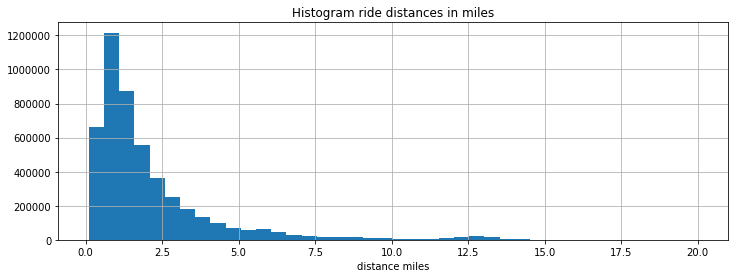

In [83]:
#histogram of haversine distance 
train_target[train_target.haversine_distnace<20].haversine_distnace.hist(bins=40, figsize=(12,4))
plt.xlabel('distance miles')
plt.title('Histogram ride distances in miles')

Text(0.5, 1.0, 'Histogram of fare amount in USD')

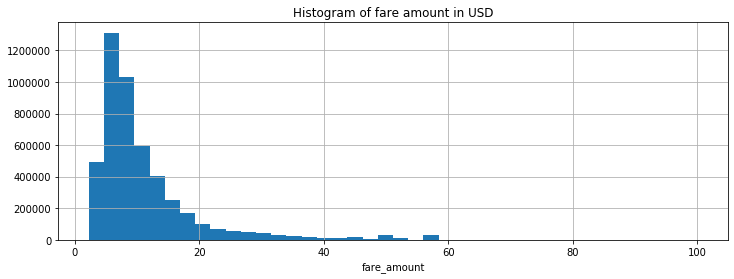

In [84]:
#histogram of fare_amount
train_target[train_target.fare_amount < 100].fare_amount.hist(bins=40, figsize=(12,4))
plt.xlabel('fare_amount')
plt.title('Histogram of fare amount in USD')

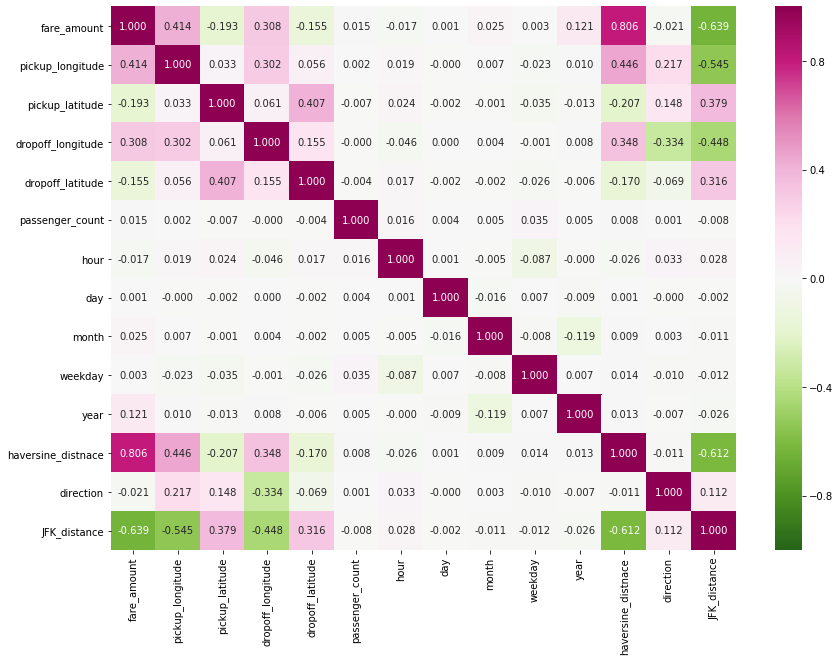

In [85]:
corrs = train_target.corr()
plt.figure(figsize = (14, 10))
sbn.heatmap(corrs, annot = True, vmin = -1, vmax = 1, fmt = '.3f', cmap=plt.cm.PiYG_r);

Text(0, 0.5, 'fare in USD')

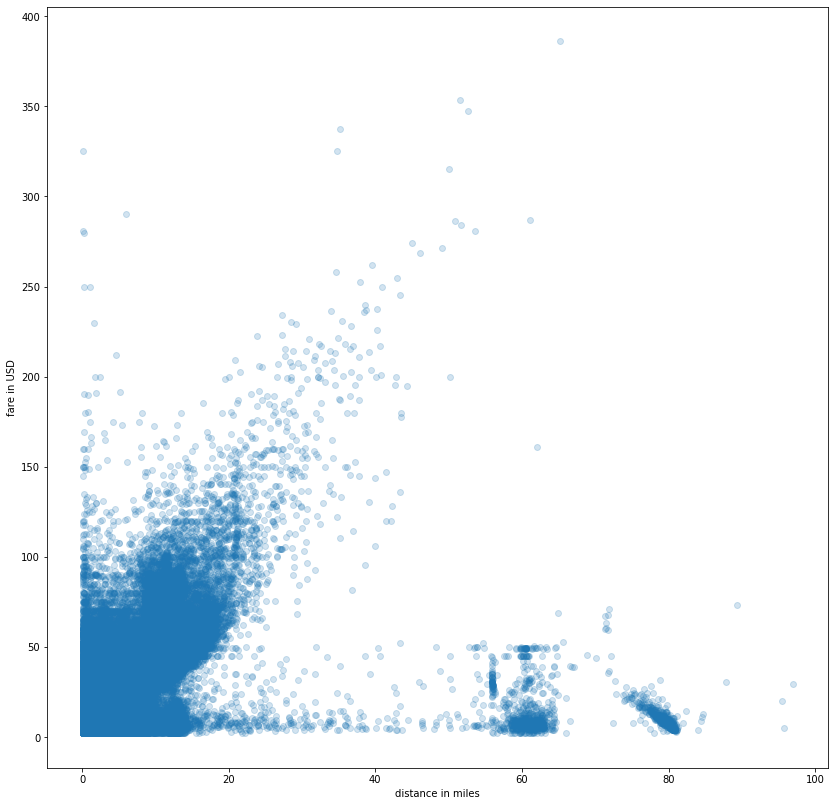

In [86]:
plt.figure(figsize = (14, 14))
plt.scatter(train_target.haversine_distnace, train_target.fare_amount, alpha=0.2)
plt.xlabel('distance in miles')
plt.ylabel('fare in USD')

Text(0, 0.5, 'fare in USD')

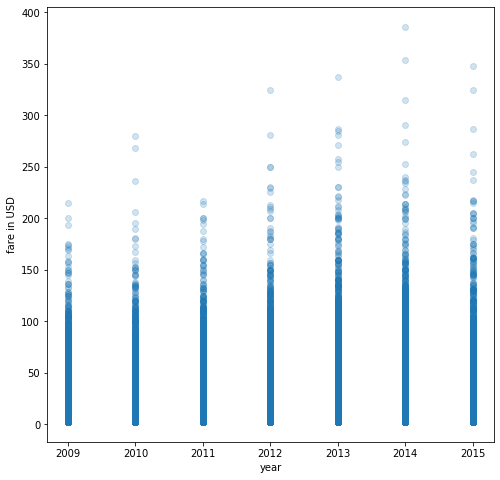

In [87]:
plt.figure(figsize = (8, 8))
plt.scatter(train_target.year, train_target.fare_amount, alpha=0.2)
plt.xlabel('year')
plt.ylabel('fare in USD')

In [88]:
#drop location features as the distance has already been calculated and added to the dataset
#features_to_drop = ['pickup_longitude',	'pickup_latitude', 'dropoff_longitude',	'dropoff_latitude', 'day', 'weekday', 'pickup_datetime']
#train_target.drop(labels = features_to_drop, axis=1, inplace=True)
print(train_target.shape)

#memory before changing datatypes
train_target.info(memory_usage='deep')

(4788773, 15)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4788773 entries, 0 to 4999998
Data columns (total 15 columns):
fare_amount           float32
pickup_datetime       datetime64[ns, UTC]
pickup_longitude      float32
pickup_latitude       float32
dropoff_longitude     float32
dropoff_latitude      float32
passenger_count       uint8
hour                  int64
day                   int64
month                 int64
weekday               int64
year                  int64
haversine_distnace    float64
direction             float32
JFK_distance          float64
dtypes: datetime64[ns, UTC](1), float32(6), float64(2), int64(5), uint8(1)
memory usage: 443.0 MB


In [89]:
#changing datatypes
train_target.month = train_target.month.astype(dtype = 'uint8')
train_target.year = train_target.year.astype(dtype = 'uint16')
train_target.hour = train_target.hour.astype(dtype = 'uint8')

#memory before changing datatypes
train_target.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4788773 entries, 0 to 4999998
Data columns (total 15 columns):
fare_amount           float32
pickup_datetime       datetime64[ns, UTC]
pickup_longitude      float32
pickup_latitude       float32
dropoff_longitude     float32
dropoff_latitude      float32
passenger_count       uint8
hour                  uint8
day                   int64
month                 uint8
weekday               int64
year                  uint16
haversine_distnace    float64
direction             float32
JFK_distance          float64
dtypes: datetime64[ns, UTC](1), float32(6), float64(2), int64(2), uint16(1), uint8(3)
memory usage: 351.7 MB


In [90]:
#drop location features as the distance has already been calculated and added to the test dataset
#features_to_drop = ['pickup_longitude',	'pickup_latitude', 'dropoff_longitude',	'dropoff_latitude', 'day', 'weekday', 'pickup_datetime']
#test_dataset.drop(labels = features_to_drop, axis=1, inplace=True)
print(test_dataset.shape)

#memory before changing datatypes
test_dataset.info(memory_usage='deep')

(9914, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 14 columns):
pickup_datetime       9914 non-null datetime64[ns, UTC]
pickup_longitude      9914 non-null float32
pickup_latitude       9914 non-null float32
dropoff_longitude     9914 non-null float32
dropoff_latitude      9914 non-null float32
passenger_count       9914 non-null uint8
hour                  9914 non-null int64
day                   9914 non-null int64
month                 9914 non-null int64
weekday               9914 non-null int64
year                  9914 non-null int64
haversine_distnace    9914 non-null float32
direction             9914 non-null float32
JFK_distance          9914 non-null float32
dtypes: datetime64[ns, UTC](1), float32(7), int64(5), uint8(1)
memory usage: 745.6 KB


In [91]:
#changing datatypes
test_dataset.month = test_dataset.month.astype(dtype = 'uint8')
test_dataset.year = test_dataset.year.astype(dtype = 'uint16')
test_dataset.hour = test_dataset.hour.astype(dtype = 'uint8')
test_dataset.haversine_distnace = test_dataset.haversine_distnace.astype(dtype = 'float64')
test_dataset.JFK_distance = test_dataset.JFK_distance.astype(dtype = 'float64')
#memory before changing datatypes
test_dataset.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 14 columns):
pickup_datetime       9914 non-null datetime64[ns, UTC]
pickup_longitude      9914 non-null float32
pickup_latitude       9914 non-null float32
dropoff_longitude     9914 non-null float32
dropoff_latitude      9914 non-null float32
passenger_count       9914 non-null uint8
hour                  9914 non-null uint8
day                   9914 non-null int64
month                 9914 non-null uint8
weekday               9914 non-null int64
year                  9914 non-null uint16
haversine_distnace    9914 non-null float64
direction             9914 non-null float32
JFK_distance          9914 non-null float64
dtypes: datetime64[ns, UTC](1), float32(5), float64(2), int64(2), uint16(1), uint8(3)
memory usage: 629.4 KB


In [92]:
y = train_target['fare_amount']
X = train_target.drop(columns=['fare_amount' , 'pickup_datetime'])

In [93]:
#building keras model
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import os
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sbn
TEST_PATH = "./test.csv"
TRAIN_PATH = "./train.csv"

def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
    
seed = 13
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=0)
print(estimator)
kfold = KFold(n_splits=10, random_state=seed)
#print(X.pickup_datetime)
results = cross_val_score(estimator, X.values, y.values, cv=kfold, n_jobs=1)
print("RMSE:", np.sqrt(results.std()))

RMSE: 1.6806163301127106
